<a href="https://colab.research.google.com/github/mohamedchnafy-ds/python_project/blob/main/project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [34]:
import pandas as pd
import os
from functools import reduce
import geopandas as gpd
from shapely.geometry import Polygon
import pandas as pd
import numpy as np
import sqlalchemy as db
from sqlalchemy import create_engine
import sqlite3
import os
import psycopg2
from urllib.parse import quote_plus
import plotly.express as px
import plotly.io as pio
from matplotlib import pyplot as plt
import json

In [3]:
# Importing the necessary library to mount Google Drive in Colab
from google.colab import drive

# Mounting Google Drive to access files stored in it
drive.mount('/content/drive')
path = '/content/drive/MyDrive/python project/input_data/'

Mounted at /content/drive


# Data

## Project Overview

The International Terrestrial Reference Frame (ITRF) uses geodetic data from observatories worldwide, with coordinates quality-controlled by instrument position measurements. However, these measurements are costly and infrequent. A working group from the International Association of Geodesy is exploring the use of InSAR (Synthetic Aperture Radar) technology to monitor relative displacements of ITRF instruments.

## InSAR Technology

InSAR uses SAR images to create deformation maps with mm/yr accuracy, requiring at least 12 images of the same area from the same acquisition geometry (relative orbit number). The project aims to catalog Sentinel 1A and 1B SAR images that cover ITRF sites with at least two instruments from different measurement techniques (GNSS, DORIS, SLR, VLBI), where instruments share the same first 5 DOMES digits.

## Objective

The goal is to collect and map the satellite footprints for these sites and integrate them into a GIS project for further analysis.

### Python Script Tasks

The Python script will:
1. Read ITRF instrument positions from the provided data files.
2. Calculate ITRF site positions.
3. Query an API to list and download satellite images covering these sites.

### Expected Output

- **SHP files** with:
  - Instruments of the processed sites.
  - Site extents.
  - Satellite image extents.

## Data

The data consists of 4 text files containing:
- **Site and instrument IDs** (e.g., 12345S123: 12345 + S123)
- **Site name**
- **Instrument type**
- **Instrument name**
- **Position (x, y, z)**
- **Position precision (x, y, z)**


In [7]:
# Read fixed-width formatted files (fwf) into DataFrames
# 'path' is the directory where the files are stored

# Load the ITRF2020 DORIS data into a DataFrame
ITRF2020_DORIS_cart = pd.read_fwf(path + 'ITRF2020_DORIS_cart.txt')

# Load the ITRF2020 GNSS data into a DataFrame
ITRF2020_GNSS_cart = pd.read_fwf(path + 'ITRF2020_GNSS_cart.txt')

# Load the ITRF2020 SLR data into a DataFrame
ITRF2020_SLR_cart = pd.read_fwf(path + 'ITRF2020_SLR_cart.txt')

# Load the ITRF2020 VLBI data into a DataFrame
ITRF2020_VLBI_cart = pd.read_fwf(path + 'ITRF2020_VLBI_cart.txt')



#### Concat Dataframes

In [8]:
# Combine multiple DataFrames into a single DataFrame using pd.concat
# 'data_frames' is a list of the individual DataFrames to be merged

data_frames = [ITRF2020_DORIS_cart, ITRF2020_GNSS_cart, ITRF2020_SLR_cart, ITRF2020_VLBI_cart]

# Concatenate the DataFrames along the rows (default axis=0)
data_merged = pd.concat(data_frames)

# The resulting DataFrame 'data_merged' contains the data from all four sources (DORIS, GNSS, SLR, VLBI)


####  Creation of geodataframe

In [22]:
# Create a GeoDataFrame from the merged data using x, y, z coordinates
# 'geometry' is created using the x, y, and z columns as point coordinates
gdf_before = gpd.GeoDataFrame(
    data_merged,
    geometry=gpd.points_from_xy(data_merged.x, data_merged.y, data_merged.z),
    crs="EPSG:4978"  # Set the Coordinate Reference System to EPSG:4978 (3D Earth-centered, Earth-fixed)
)

# Convert the CRS to WGS 84 (latitude/longitude) EPSG:4326
gdf = gdf_before.to_crs(4326)

# Extract 'site_id' from the 'id' column using regex: numbers (digits)
gdf['site_id'] = gdf['id'].str.extract('(\d+)')

# Extract 'instrument_id' from the 'id' column using regex: alphabetic characters after digits
gdf['instrument_id'] = gdf['id'].str.extract('\d+([A-Za-z].+)')

# Group by 'site_id' and aggregate to count unique instruments and types
summary_gdf = gdf.groupby('site_id').agg(
    instrument_nb=('instrument_id', 'count'),  # Count the number of unique instrument IDs for each site
    types=('type', 'nunique')  # Count the number of unique types for each site
).reset_index()

# Rename the columns to be more descriptive
summary_gdf.columns = ['site_id', 'instrument_nb', 'types']

# Display the summary GeoDataFrame
summary_gdf


,site_id,instrument_nb,types
0,10001,2,1
1,10002,7,4
2,10003,6,2
3,10004,3,2
4,10012,2,1
...,...,...,...
1241,97309,1,1
1242,97401,4,2
1243,97413,1,1
1244,97415,1,1


In [23]:
# Filter summary_gdf to keep sites with at least 3 instruments and 2 unique types
summary_gdf = summary_gdf[(summary_gdf.instrument_nb >= 3) & (summary_gdf.types >= 2)]

# Filter gdf to keep only sites from the filtered summary_gdf
gdf_site = gdf[gdf['site_id'].isin(summary_gdf.site_id.tolist())]

# Display the filtered GeoDataFrame with selected sites
gdf_site


,id,name,type,code,x,y,z,dx,dy,dz,geometry,site_id,instrument_id
0,10002S018,Grasse (OCA),DORIS,GR3B,4.581680e+06,5.561665e+05,4.389372e+06,0.002,0.0025,0.002,POINT Z (6.92123 43.75483 1323.70087),10002,S018
1,10002S019,Grasse (OCA),DORIS,GR4B,4.581681e+06,5.561669e+05,4.389371e+06,0.0019,0.0024,0.0017,POINT Z (6.92123 43.75483 1323.8158),10002,S019
2,10003S001,Toulouse,DORIS,TLSA,4.628047e+06,1.196707e+05,4.372788e+06,0.0054,0.0062,0.0051,POINT Z (1.48121 43.55814 207.69101),10003,S001
3,10003S003,Toulouse,DORIS,TLHA,4.628693e+06,1.199851e+05,4.372105e+06,0.0034,0.0042,0.0032,POINT Z (1.48489 43.54962 210.79597),10003,S003
4,10003S005,Toulouse,DORIS,TLSB,4.628694e+06,1.199851e+05,4.372105e+06,0.0026,0.0039,0.0025,POINT Z (1.48489 43.54962 211.08413),10003,S005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,50107S012,Yarragadee,VLBI,7376,-2.388896e+06,5.043350e+06,-3.078591e+06,0.0012,0.0014,0.0013,POINT Z (115.34563 -29.04714 248.2326),50107,S012
147,50116S002,Hobart,VLBI,7242,-3.950237e+06,2.522348e+06,-4.311562e+06,0.0014,0.0012,0.0014,POINT Z (147.44052 -42.80358 65.08972),50116,S002
148,50116S007,Hobart,VLBI,7374,-3.949991e+06,2.522421e+06,-4.311708e+06,0.0014,0.0012,0.0015,POINT Z (147.43814 -42.80557 40.95217),50116,S007
152,66006S004,Syowa,VLBI,7342,1.766194e+06,1.460411e+06,-5.932273e+06,0.0034,0.0031,0.0071,POINT Z (39.58628 -69.00632 51.02068),66006,S004


In [24]:
# Group by 'site_id', count 'instrument_id' and get unique 'type' per site
sites_dissolved = gdf.dissolve(
    by='site_id',
    aggfunc={'instrument_id': 'count', 'type': 'nunique'}
).reset_index()

sites_dissolved

,site_id,geometry,instrument_id,type
0,10001,"MULTIPOINT Z (2.33494 48.83592 122.58673, 2.33...",2,1
1,10002,"MULTIPOINT Z (6.92058 43.75474 1319.30335, 6.9...",7,4
2,10003,"MULTIPOINT Z (1.48076 43.56077 207.09635, 1.48...",6,2
3,10004,"MULTIPOINT Z (-4.50383 48.40787 104.42082, -4....",3,2
4,10012,"MULTIPOINT Z (7.22726 43.70327 256.49109, 7.29...",2,1
...,...,...,...,...
1241,97309,POINT Z (-52.58675 5.28468 -28.00331),1,1
1242,97401,"MULTIPOINT Z (55.57172 -21.20822 1558.37142, 5...",4,2
1243,97413,POINT Z (55.28449 -20.9644 23.10689),1,1
1244,97415,POINT Z (55.49523 -20.89676 49.27391),1,1


In [25]:
def multipoint_to_polygon(geometry):

    return geometry.convex_hull

sites_polygons = sites_dissolved.copy()
sites_polygons.geometry = sites_polygons.geometry.apply(multipoint_to_polygon)

In [26]:
sites_polygons

,site_id,geometry,instrument_id,type
0,10001,"LINESTRING Z (2.33494 48.83592 122.58673, 2.33...",2,1
1,10002,"POLYGON Z ((6.92077 43.75449 1319.85842, 6.920...",7,4
2,10003,"POLYGON Z ((1.48489 43.54962 210.79597, 1.4812...",6,2
3,10004,"POLYGON Z ((-4.49659 48.3805 65.82489, -4.5038...",3,2
4,10012,"LINESTRING Z (7.22726 43.70327 256.49109, 7.29...",2,1
...,...,...,...,...
1241,97309,POINT Z (-52.58675 5.28468 -28.00331),1,1
1242,97401,"POLYGON Z ((55.57176 -21.20899 1561.14383, 55....",4,2
1243,97413,POINT Z (55.28449 -20.9644 23.10689),1,1
1244,97415,POINT Z (55.49523 -20.89676 49.27391),1,1


In [27]:
sites_polygons.describe

<bound method NDFrame.describe of      site_id                                           geometry  \
0      10001  LINESTRING Z (2.33494 48.83592 122.58673, 2.33...   
1      10002  POLYGON Z ((6.92077 43.75449 1319.85842, 6.920...   
2      10003  POLYGON Z ((1.48489 43.54962 210.79597, 1.4812...   
3      10004  POLYGON Z ((-4.49659 48.3805 65.82489, -4.5038...   
4      10012  LINESTRING Z (7.22726 43.70327 256.49109, 7.29...   
...      ...                                                ...   
1241   97309              POINT Z (-52.58675 5.28468 -28.00331)   
1242   97401  POLYGON Z ((55.57176 -21.20899 1561.14383, 55....   
1243   97413               POINT Z (55.28449 -20.9644 23.10689)   
1244   97415              POINT Z (55.49523 -20.89676 49.27391)   
1245   97501               POINT Z (-56.16825 46.77782 0.45378)   

      instrument_id  type  
0                 2     1  
1                 7     4  
2                 6     2  
3                 3     2  
4                 2     1  
...             ...   ...  
1241              1     1  
1242              4     2  
1243              1     1  
1244              1     1  
1245              1     1  

[1246 rows x 4 columns]>

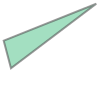

In [28]:
sites_polygons.geometry[3]

In [35]:
def get_and_cache_images(sites_polygons, temp_dir="temp_files"):
    """Fetches Copernicus images, caches them, and creates a GeoDataFrame.

    Args:
        sites_polygons: GeoDataFrame with a 'geometry' column containing site polygons.
        temp_dir: Directory to store cached JSON files.

    Returns:
        A GeoDataFrame containing image information.
    """
    os.makedirs(temp_dir, exist_ok=True)  # Create the temp_dir if it doesn't exist
    all_images = []  # List to store all fetched images

    # Loop through each site in the GeoDataFrame
    for idx, geometry in enumerate(sites_polygons.geometry):
        site_id = sites_polygons.index[idx]  # Get the site ID
        temp_file = os.path.join(temp_dir, f"{site_id}.json")  # Cache file for this site

        # If cache file exists and is not empty, load images from cache
        if os.path.exists(temp_file) and os.path.getsize(temp_file) > 0:
            with open(temp_file, 'r') as f:
                images = json.load(f)
        else:
            # If no cache, make an API request to fetch images
            items = []
            r = requests.get(
                "https://catalogue.dataspace.copernicus.eu/resto/api/collections/Sentinel2/search.json",
                params={
                    "geometry": geometry,  # Use the site geometry
                    "startDate": "2022-01-01T00:00:00.000Z",  # Start date
                    "completionDate": "2022-09-30T23:59:59.999Z",  # End date
                    "cloudCover": "[0,10]",  # Cloud cover filter
                    "maxRecords": 20,  # Limit to 20 records
                    "page": 1,  # First page
                }
            )
            if r.status_code == 200:
                data = r.json()
                if 'features' in data:
                    items += data['features']
            images = items
            with open(temp_file, 'w') as f:
                json.dump(images, f)  # Save the fetched images to cache

        all_images.append(images)

    # Create the GeoDataFrame
    all_gdf = gpd.GeoDataFrame(columns=['id', 'title', 'url'])
    for features in all_images:
        gdf = gpd.GeoDataFrame(
            data=[{
                'id': f['id'],
                'title': f['properties']['title'],
                'url': f['properties']['services']['download']['url']
            } for f in features]
        )
        all_gdf = pd.concat([all_gdf, gdf], ignore_index=True)  # Concatenate the new data

    return all_gdf  # Return the GeoDataFrame


In [36]:
one_geodataframe = get_and_cache_images(sites_polygons)
one_geodataframe

,id,title,url
0,c6ac9f84-4d18-5bd8-b42b-570b47b59083,S2B_MSIL1C_20220717T105629_N0400_R094_T31UDQ_2...,https://catalogue.dataspace.copernicus.eu/down...
1,3fbabe1e-2cb8-5956-b103-be9458e5cb57,S2B_MSIL2A_20220717T105629_N0400_R094_T31UDQ_2...,https://catalogue.dataspace.copernicus.eu/down...
2,52685e5d-2047-536c-b538-2ecf6c4e8b90,S2A_MSIL1C_20220719T105041_N0400_R051_T31UDQ_2...,https://catalogue.dataspace.copernicus.eu/down...
3,d61fea79-0a1e-5a44-864a-82e01a62cdd1,S2A_MSIL2A_20220719T105041_N0400_R051_T31UDQ_2...,https://catalogue.dataspace.copernicus.eu/down...
4,ff6ebcb1-aa8a-53a0-a063-fcbc5ff7a0d3,S2B_MSIL1C_20220813T104629_N0400_R051_T31UDQ_2...,https://catalogue.dataspace.copernicus.eu/down...
...,...,...,...
23196,9ddd1d7d-e82d-54a1-a8b8-ca463c52cebc,S2A_MSIL1C_20220509T144801_N0400_R039_T21TWM_2...,https://catalogue.dataspace.copernicus.eu/down...
23197,43461257-505b-5174-9746-73927e6e969f,S2A_MSIL1C_20220728T144811_N0400_R039_T21TWM_2...,https://catalogue.dataspace.copernicus.eu/down...
23198,00b79f55-a1e1-507e-be6d-87340658fe35,S2A_MSIL2A_20220509T144801_N0400_R039_T21TWM_2...,https://catalogue.dataspace.copernicus.eu/down...
23199,2f63c790-8db2-512f-bf11-1bef4a3fd42f,S2A_MSIL1C_20220519T144801_N0400_R039_T21TWM_2...,https://catalogue.dataspace.copernicus.eu/down...
